In [2]:
# Mount Google Drive to access your file
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


       DATE  IPG2211A2N
0  1/1/1985     72.5052
1  2/1/1985     70.6720
2  3/1/1985     62.4502
3  4/1/1985     57.4714
4  5/1/1985     55.3151


<Axes: title={'center': 'Electric Production Over Time'}, xlabel='DATE'>

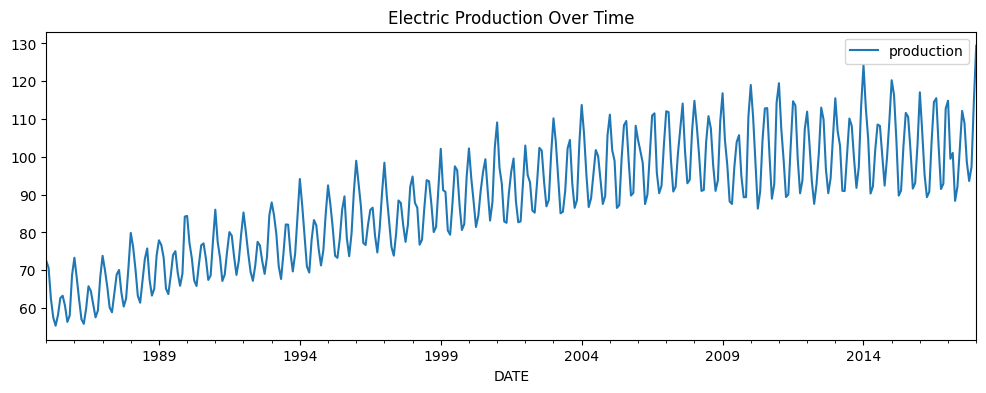

In [3]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Electric_Production.csv')

# Preview data
print(df.head())

# Parse date if needed and set index
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# Rename value column for simplicity
df.rename(columns={'IPG2211A2N': 'production'}, inplace=True)

# Plot to visualize trend
df.plot(title="Electric Production Over Time", figsize=(12, 4))


In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale data to range [0, 1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['production']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12  # 12 months lookback
X, y = create_sequences(scaled_data, seq_length)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [5]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.1339 - val_loss: 0.0220
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0205 - val_loss: 0.0247
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - val_loss: 0.0188
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - val_loss: 0.0187
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0152 - val_loss: 0.0183
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0139 - val_loss: 0.0189
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0128 - val_loss: 0.0194
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - val_loss: 0.0186
Epoch 9/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - val_loss: 0.0219
Epoch 10/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0137 - val_loss: 0.0177
Epoch 11/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - val_loss: 0.0184
Epoch 12/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0124 - 

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


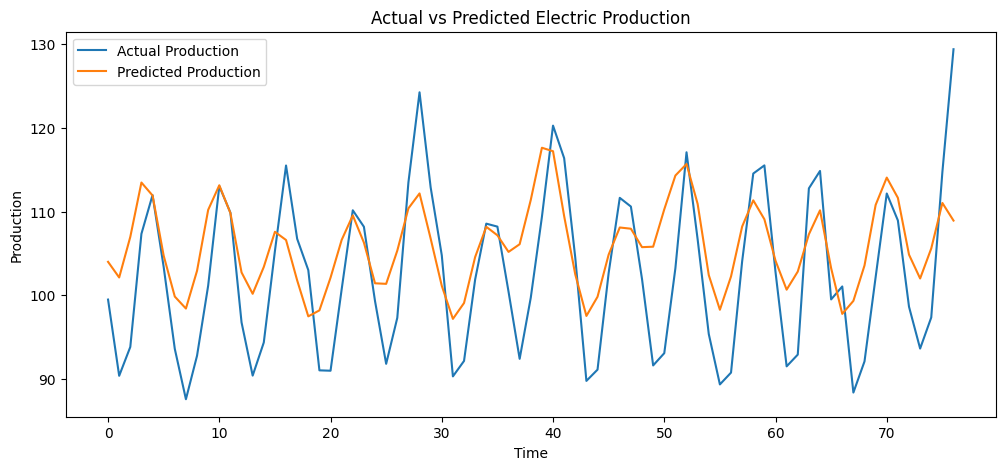

In [6]:
import matplotlib.pyplot as plt

# Predict
predicted = model.predict(X_test)
predicted_unscaled = scaler.inverse_transform(predicted)
actual_unscaled = scaler.inverse_transform(y_test)

# Plot results
plt.figure(figsize=(12, 5))
plt.plot(actual_unscaled, label='Actual Production')
plt.plot(predicted_unscaled, label='Predicted Production')
plt.legend()
plt.title('Actual vs Predicted Electric Production')
plt.xlabel('Time')
plt.ylabel('Production')
plt.show()


In [7]:
# Forecast next value
last_sequence = X_test[-1].reshape(1, seq_length, 1)
next_pred_scaled = model.predict(last_sequence)
next_pred = scaler.inverse_transform(next_pred_scaled)
print(f"Forecasted next production value: {next_pred[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Forecasted next production value: 108.92
